# BL40A2020 Wireless Communication Systems

## Week 3: Digital modulation - Lecture material - 12.11.2018

## Author: Pedro Nardelli


In [1]:
! pip install scikit-dsp-comm

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install komm

     |████████████████████████████████| 51kB 3.8MB/s eta 0:00:01
  Created wheel for komm: filename=komm-0.7.0-cp36-none-any.whl size=57179 sha256=544d372760a468a777a5e349d29ea22d3183034df400eb840ed7dcc527a0458b
  Stored in directory: /home/nbuser/.cache/pip/wheels/80/4d/62/4b6f1375890de14c3712338dd6aea61f33f1bbccd5d526365c
Successfully built komm
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import math
import komm
import sympy as sp
sp.init_printing() 
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

# Analog modulation

# Message signal and transmitted signal

- Message: $m(t) \longrightarrow$ Baseband signal
- Transmitted $u_\mathrm{p}(t) \longrightarrow$  Passband signal 

**Example: Double-sideband (DSB) suppressed carrier (SC)**
 

- $u_\mathrm{DSB}(t) = A m(t) \cos\left(2\pi f_\mathrm{c}t\right)$

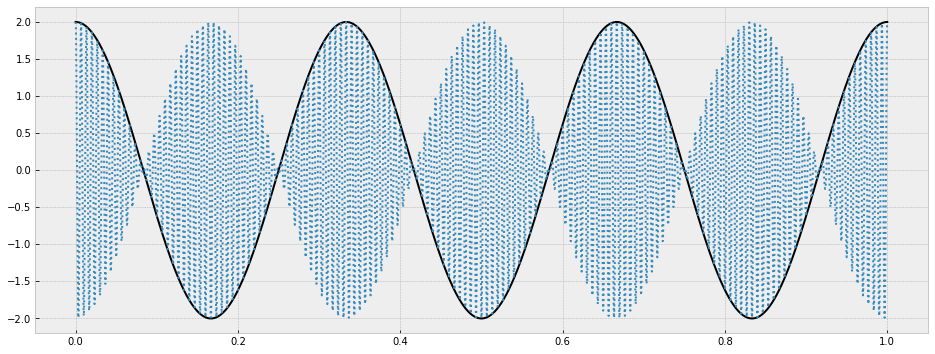

In [4]:
amp_c = 1
freq_c = 150
amp_m = 2
freq_m = 3
#
m,t,Am,fm,f,w = sp.symbols('a, t, A_m, f_m, f,omega')
A,fc = sp.symbols('A,f_c')
g = sp.Function('g')
m = Am * sp.cos(2*sp.pi*fm*t) 
uDSB = A *g(t) * sp.cos(2*sp.pi*fc*t)
modulated = uDSB.subs(g(t),m)
m_example = m.subs(Am,amp_m).subs(fm,freq_m)
modulated_signal = uDSB.subs(fc,freq_c).subs(A,amp_c).subs(g(t),m_example)
message =  sp.lambdify(t,m.subs(Am,amp_m ).subs(fm,freq_m),"numpy")
modulation_only = sp.lambdify(t,uDSB.subs(fc,freq_c).subs(A,amp_c).subs(g(t),1),"numpy")
#plt.plot(tp, modulation(tp),linestyle='--')
fp = 4000 #measurments per second
tp = np.linspace(0, 1, fp)
plt.rcParams['figure.figsize'] = 16, 6
plt.plot(tp,  amp_c*message(tp),'k-',label='A_c*message')
plt.plot(tp, modulation_only(tp)*message(tp),':');

# Digital modulation


## Signal constellation

The linear modulated signal is:

$$u(t) = \sum\limits_{n} b[n] p(t-nT),$$

where $\{b[n]\}$ is the sequence of symbols and $p(t)$ the modulating pulse.

The modulated wave form is baseband that can be sent via a passband signal:

$$u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi f_\mathrm{c} t) - u_\mathrm{s}(t)\sin(2\pi f_\mathrm{c} t).$$

And the complex envelope of $u_\mathrm{p}(t)$ is given by $u(t) = u_\mathrm{c}(t) + j u_\mathrm{s}(t)$. Due to orthogonality:

$$u(t) = u_\mathrm{c}(t) + j u_\mathrm{s}(t) = \sum\limits_{n} (b_\mathrm{c}[n] + j b_\mathrm{s}[n])  p(t-nT) = \sum\limits_{n} b[n] p(t-nT).$$

- $p(t)$ is the modulating pulse. For example: a retangular wave form (time-limited) or a sinc-function (frequency-limited).
- Input bits arrive at a given rate $R_\mathrm{in}$ (bits/s) that shall be coded following the modulation.
- The modulation that has cardinatility $M = 2^h$, where $h = \log_2 M$ is the number of bits in a symbol.
- A sequence of $n$ symbols implies a sequence of $n \cdot \log_2 M$ input bits.
- $T$ is the symbol period. 
- The symbol rate $R$ (symbols/s) is equal to $R_\mathrm{in}/\log_2 M$.
- The modulation maps the input binary sequence in in-phase and quadrature terms $b_\mathrm{c}[n]$ and  $b_\mathrm{s}[n]$.
- The set of all possible complex numbers $b_\mathrm{c}[n] + j b_\mathrm{s}[n]$ in a given modulation is called constellation.

## Pulse-amplitude modulation (2-PAM)

- $p(t)$ is a retangular pulse with duration $T$.

Bit-to-symbol map: 
- Input 0: $ b_\mathrm{c}[n] = -a$, 
- Input 1: $ b_\mathrm{c}[n] = +a$
- $ b_\mathrm{s}[n] = 0$

Let us analyze a numerical example where $a=2$ based on [Komm](https://komm.readthedocs.io/en/latest/).

In [5]:
a = 1
pam = komm.PAModulation(2, base_amplitude=a)

In [6]:
pam.constellation

array([-1.,  1.])

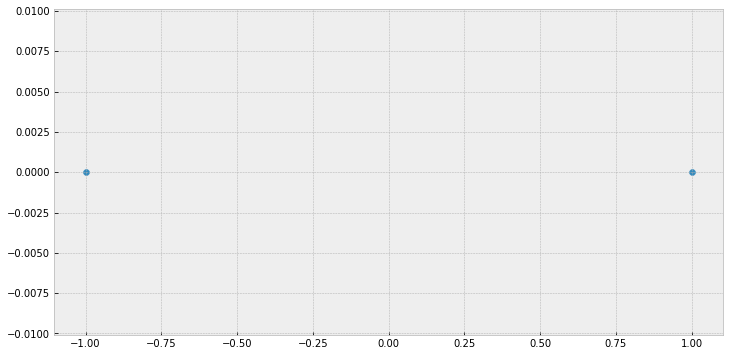

In [7]:
plt.rcParams['figure.figsize'] = 12, 6
plt.scatter(pam.constellation.real,pam.constellation.imag);

**Example** 

Now we are going to analyse a 20-element binary input sequece of 0's and 1's.

In [8]:
input_seq_size = 50
tp = np.arange(0, input_seq_size , 1) # time / period = 1 bit per period
input_seq = np.random.randint(2, size=input_seq_size)
print("Input sequence:", input_seq)
print("Length:", len(input_seq))

Input sequence: [1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1
 1 1 0 1 0 0 1 0 0 1 0 1 1]
Length: 50


If the bit rate is, for example, 100 bits per second, every bit has a period of 0.01 second.

*The input signal is plotted below.*

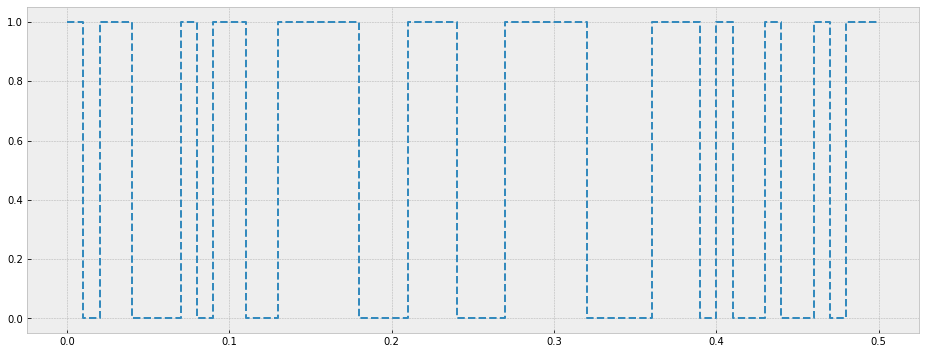

In [9]:
input_rate = 100
plt.rcParams['figure.figsize'] = 16, 6
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1)/input_rate #Need to convert this to seconds
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--');

*And the modulating PAM pulse is:*

Input sequence: [1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1
 1 1 0 1 0 0 1 0 0 1 0 1 1]
Modulating sequence: [ 1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.
 -1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.]


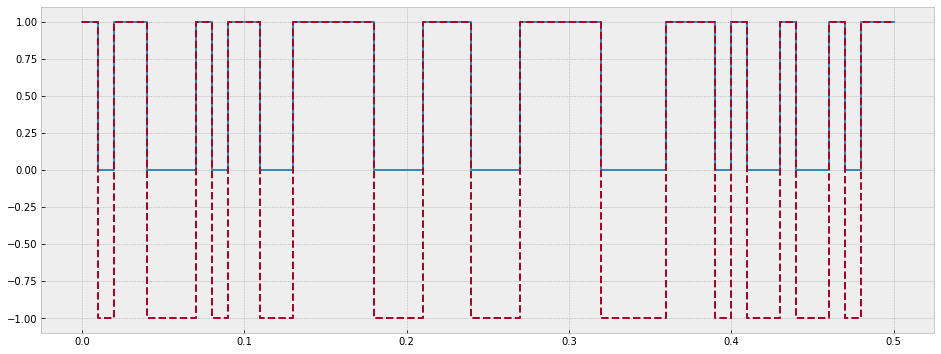

In [10]:
print("Input sequence:", input_seq)
print("Modulating sequence:", pam.modulate(input_seq))
plt.step(tp_plot,input_seq_plot,where='post')
plt.step(tp_plot,pam.modulate(input_seq_plot),where='post',linestyle='--')
plt.show()

Let us now define the wave forms using sympy.

In [11]:
t,fc = sp.symbols('t,f_c')
pam_wave = sp.cos(2*sp.pi*fc*t)
pam_wave

We consider a carrier frequency $f_c$.

In [12]:
#Numerical example with f_c 
freq_c = 200
pam_modulation = sp.lambdify(t,pam_wave.subs(fc,freq_c),"numpy")

In [13]:
#How many point will be evaluated to plot the wave form curve - 100 times the input sequence length
tmod_points = 100*input_seq_size
#Creating this array with these points
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
#To calculate t, it is needed to build a new array with this granularity.
input_wave_aux = pam.modulate(input_seq)
input_wave_I_aux = input_wave_aux.real
input_wave_I = np.zeros(tmod_points)
#input_wave_I[0] = input_wave_aux[0]
##################################
for i in range(0, tmod_points):
    aux = math.floor(i/100)
    if input_wave_I_aux[aux] > 0: 
        input_wave_I[i] = a
    else:
        input_wave_I[i] = -a

Check the plots to see if the conversion was right.

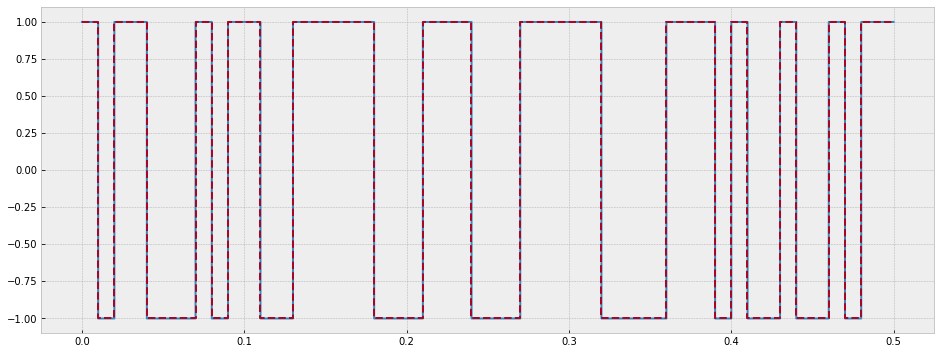

In [14]:
plt.step(tmod,input_wave_I,where='post')
plt.step(tp_plot,pam.modulate(input_seq_plot),linestyle='--',where='post')
plt.show()

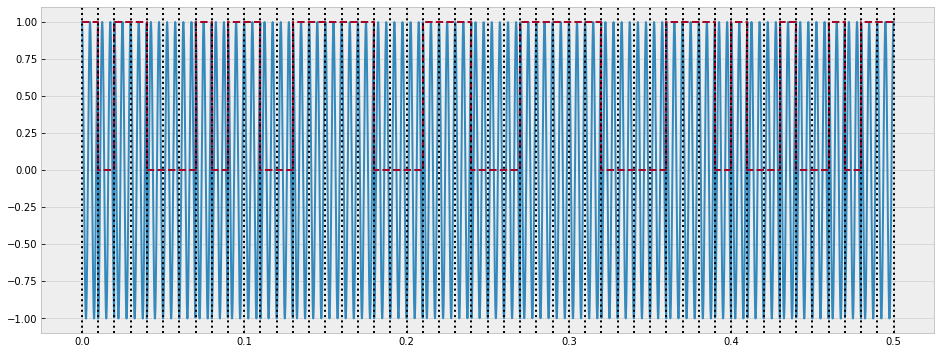

In [15]:
plt.plot(tmod,input_wave_I*pam_modulation(tmod))
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')
for i in range(input_seq_size + 1):
    plt.axvline(i/input_rate,linestyle=':',color='k');
plt.show()

## Quadrature-amplitude modulation (M-QAM)

- $p(t)$  is a retangular pulse with duration  $T$.
- Every $M$ bits in the input sequence lead to a different point in the *constelation* that comes from: $u_\mathrm{p}(t) = u_\mathrm{c}(t)\cos(2\pi f_\mathrm{c} t) - u_\mathrm{s}(t)\sin(2\pi f_\mathrm{c} t).$
- The constalation is determined by the complex number associated with the combination of $u_\mathrm{p}(t)$ and $u_\mathrm{p}(t)$ related to the 4-bit sequence.
- There exist $2^M$ possible binary sequences so the modulation is known as M-QAM.
- It is a complex modulation: Orthogonal components (cosine and sine with the same frequency, they do not interfere to each other).

We are going to use another library called [Komm](https://komm.readthedocs.io/en/latest/) to define the QAM modulation.

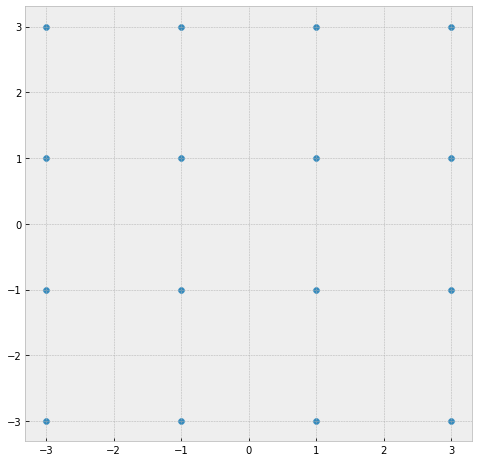

In [16]:
#M-QAM
M=16
qam = komm.QAModulation(M)
#qam = komm.QAModulation(orders=(8, 4), base_amplitudes=(1.0, 2.0))
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(qam.constellation.real,qam.constellation.imag);

Let us make a similar analysis as we did with PAM.

In [17]:
observations = int # defining the number of symbols observed as an integer
observations = 12 # number sequences of 4 bits since the 16-QAM needs sequences of 4 bits
rate = 400 #bits per second
input_seq_size = observations * np.log2(M).astype(int)
time_of_obs = input_seq_size/rate
tp = np.arange(0, input_seq_size, 1)/rate 
input_seq = np.random.randint(2, size=input_seq_size)
print("Symbols")
print(observations)
print("Input sequence", "length:", len(input_seq))
print(input_seq)
print("Modulated with 16QAM","length:", len(np.around(qam.modulate(input_seq),decimals=3)))
print(np.around(qam.modulate(input_seq),decimals=3))

Symbols
12
Input sequence length: 48
[0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1
 1 0 1 0 1 0 0 1 1 1 0]
Modulated with 16QAM length: 12
[-3.+3.j -1.+3.j  1.-1.j -3.+3.j  3.-1.j  1.+1.j  3.+1.j  1.-1.j  3.+3.j
  1.+3.j  3.-3.j  1.-1.j]


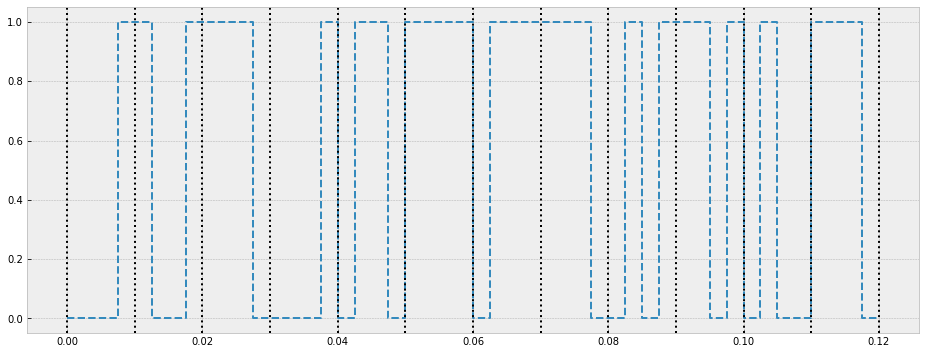

In [18]:
plt.rcParams['figure.figsize'] = 16, 6
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/rate)
plt.step(tp_plot,input_seq_plot,where='post',linestyle='--')
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');

In [19]:
n_samples = 30
tmod_points = n_samples*input_seq_size
#
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
#
input_wave_aux = qam.modulate(input_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)
##################################
for i in range(0,tmod_points):
    aux = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[aux],decimals=3) == np.around(qam.constellation[j],decimals=3): 
            input_wave_I[i] = qam.constellation[j].real 
            input_wave_Q[i] = qam.constellation[j].imag

Plotting the modulating in-phase and quadrature pulses.

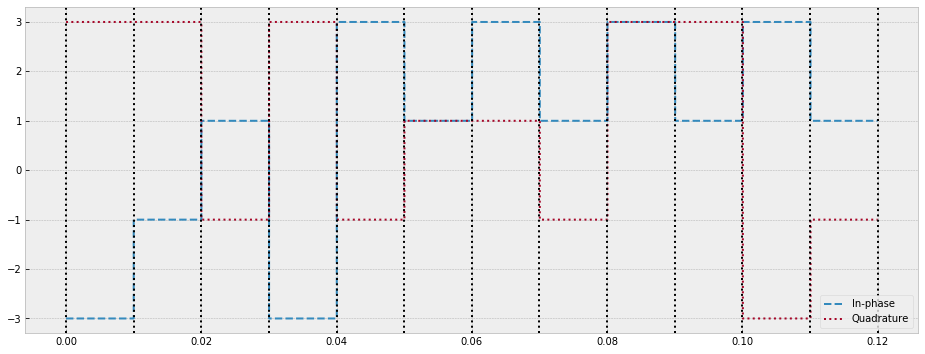

In [20]:
plt.step(tmod,input_wave_I,where='post',linestyle='--',label='In-phase')
plt.step(tmod,input_wave_Q,where='post',linestyle=':',label='Quadrature')
plt.legend(loc='lower right')
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');

Considering the frequency of the carrier $f_c=600$ Hz, we have the 16-QAM wave form for the input sequence.

Defining the wave forms (in sympy).

In [21]:
uc = sp.cos(2*sp.pi*fc*t)
us = sp.sin(2*sp.pi*fc*t)

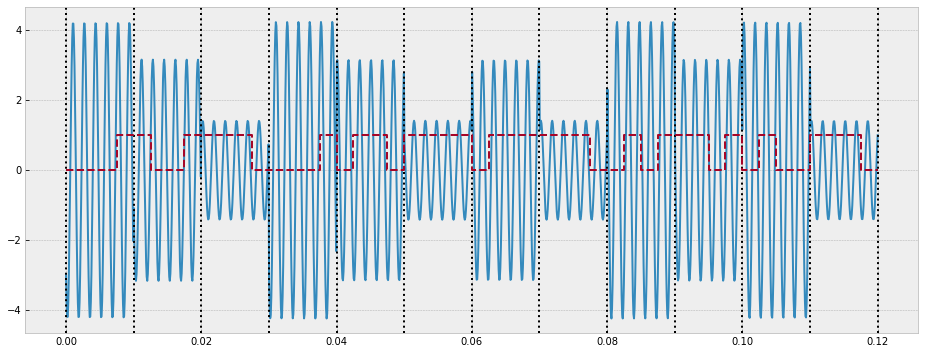

In [22]:
freq_c = 600
modulation_I = sp.lambdify(t,uc.subs(fc,freq_c),"numpy")
modulation_Q = sp.lambdify(t,us.subs(fc,freq_c),"numpy")
plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')
plt.show()

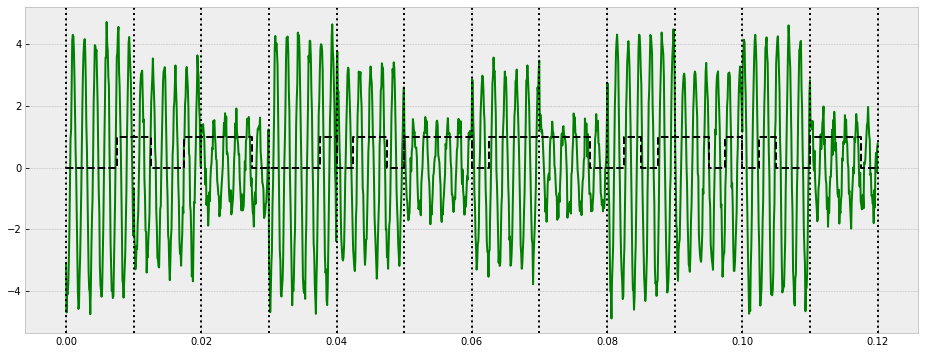

In [23]:
freq_c = 600
mu, sigma = 0, 0.2 # mean and standard deviation
noiseQ = np.random.normal(mu, sigma, tmod_points)
noiseI = np.random.normal(mu, sigma, tmod_points)
plt.plot(tmod,(input_wave_I*modulation_I(tmod) + noiseI) - (input_wave_Q*modulation_Q(tmod) + noiseQ),'g')
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--',color='k')
plt.show()

## Frequency analysis

- Power spectral density: Distribution of power into frequency components
- $S_x \approx \dfrac{|X_{T_0}(f)|^2}{T_0}$, where $T_0$ is the observation time 
- Analytically computed for $T_0$ growing to infinity.


### Bandwidth in 16-QAM - example 4.2.1
- 4 bits per symbol -> rate 400 bits per second -> 100 symbols per second = 1/T
- 99% of power is the bandwidth -> B = 10.2 -> B/T = 100 * 10.2 = 1020 Hz
- 90% of power is the bandwidth -> B = 0.85 -> B/T = 100 * 0.85 = 85 Hz

Let's check it for the numerical example given. I am using the [fft from scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html), but you could use any other library as well.

In [24]:
#We need to normalize the values by the number of samples per second.
X = fftpack.fft(input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod)) / (tmod_points/tp_plot[input_seq_size])
#To get the frequency, we need to match the number of points of XinI and then normalize by the number of samples per second.
freq = fftpack.fftfreq(len(input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))) * tmod_points/tp_plot[input_seq_size]
#Using this fftshift, we can arrange the output array to make the plot.
X = fftpack.fftshift(X)
freq = fftpack.fftshift(freq)
absX = np.abs(X) 

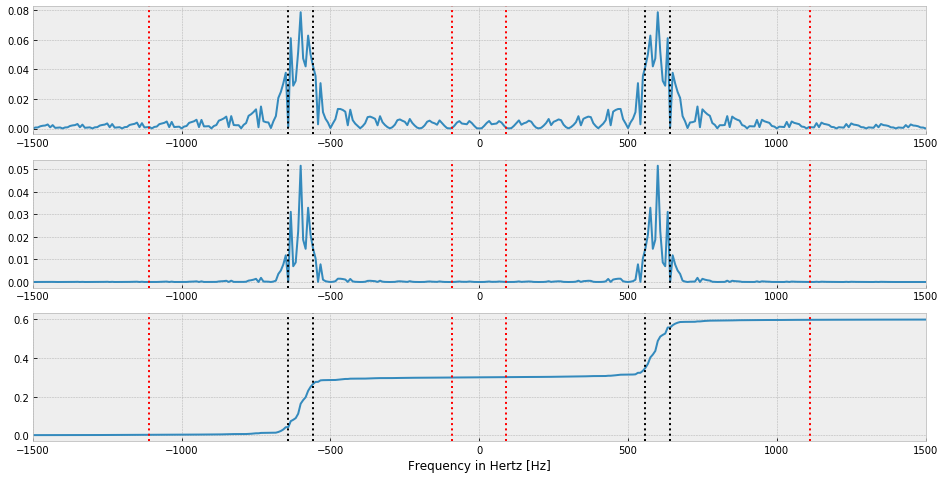

In [25]:
plt.rcParams['figure.figsize'] = 16, 8
ax = plt.subplot(311)
ax.plot(freq,absX)
ax.axvline(freq_c-85/2,linestyle=':',color='k')
ax.axvline(freq_c+85/2,linestyle=':',color='k')
ax.axvline(freq_c-510,linestyle=':',color='r')
ax.axvline(freq_c+510,linestyle=':',color='r')
ax.axvline(-freq_c-85/2,linestyle=':',color='k')
ax.axvline(-freq_c+85/2,linestyle=':',color='k')
ax.axvline(-freq_c-510,linestyle=':',color='r')
ax.axvline(-freq_c+510,linestyle=':',color='r')
ax.set_xlim(-1500, 1500);
ax1 = plt.subplot(312)
ax1.plot(freq,absX**2 / tp_plot[input_seq_size])
ax1.axvline(freq_c-85/2,linestyle=':',color='k')
ax1.axvline(freq_c+85/2,linestyle=':',color='k')
ax1.axvline(freq_c-510,linestyle=':',color='r')
ax1.axvline(freq_c+510,linestyle=':',color='r')
ax1.axvline(-freq_c-85/2,linestyle=':',color='k')
ax1.axvline(-freq_c+85/2,linestyle=':',color='k')
ax1.axvline(-freq_c-510,linestyle=':',color='r')
ax1.axvline(-freq_c+510,linestyle=':',color='r')
ax1.set_xlim(-1500, 1500);
ax2 = plt.subplot(313)
ax2.plot(freq,np.cumsum(absX**2 /tp_plot[input_seq_size]))
ax2.axvline(freq_c-85/2,linestyle=':',color='k')
ax2.axvline(freq_c+85/2,linestyle=':',color='k')
ax2.axvline(freq_c-510,linestyle=':',color='r')
ax2.axvline(freq_c+510,linestyle=':',color='r')
ax2.axvline(-freq_c-85/2,linestyle=':',color='k')
ax2.axvline(-freq_c+85/2,linestyle=':',color='k')
ax2.axvline(-freq_c-510,linestyle=':',color='r')
ax2.axvline(-freq_c+510,linestyle=':',color='r')
ax2.set_xlabel('Frequency in Hertz [Hz]')
ax2.set_xlim(-1500, 1500);

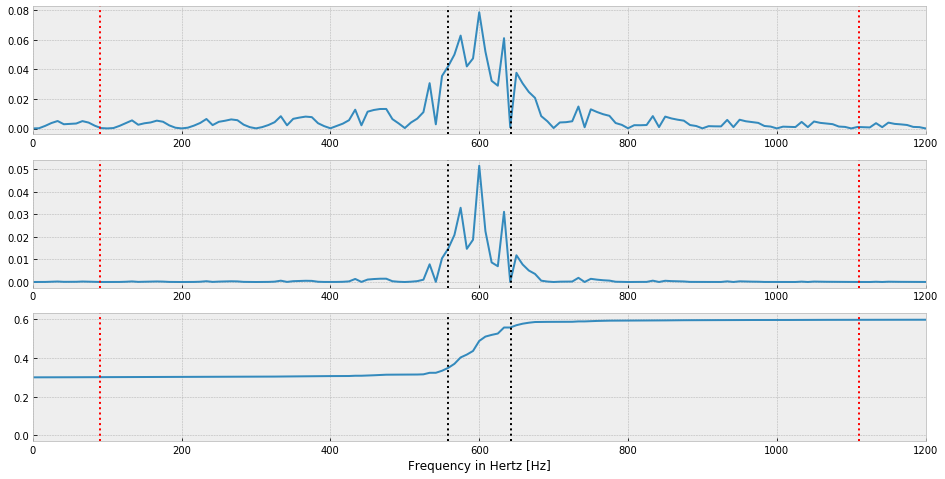

In [26]:
plt.rcParams['figure.figsize'] = 16, 8
ax = plt.subplot(311)
ax.plot(freq,absX)
ax.axvline(freq_c-85/2,linestyle=':',color='k')
ax.axvline(freq_c+85/2,linestyle=':',color='k')
ax.axvline(freq_c-510,linestyle=':',color='r')
ax.axvline(freq_c+510,linestyle=':',color='r')
ax.set_xlim(0, freq_c+600);
ax1 = plt.subplot(312)
ax1.plot(freq,absX**2 / tp_plot[input_seq_size])
ax1.axvline(freq_c-85/2,linestyle=':',color='k')
ax1.axvline(freq_c+85/2,linestyle=':',color='k')
ax1.axvline(freq_c-510,linestyle=':',color='r')
ax1.axvline(freq_c+510,linestyle=':',color='r')
ax1.set_xlim(0, freq_c+600);
ax2 = plt.subplot(313)
ax2.plot(freq,np.cumsum(absX**2 /tp_plot[input_seq_size]))
ax2.axvline(freq_c-85/2,linestyle=':',color='k')
ax2.axvline(freq_c+85/2,linestyle=':',color='k')
ax2.axvline(freq_c-510,linestyle=':',color='r')
ax2.axvline(freq_c+510,linestyle=':',color='r')
ax2.set_xlabel('Frequency in Hertz [Hz]')
ax2.set_xlim(0, freq_c+600);

Although the 99% and 90% assume a long enough input sequence so the effects of particular sequence realization, it is clear that these limits are good indicative of the bandwidht occupance.

**Retangular pulse leads to a sinc in the frequency domain, which is not limited**

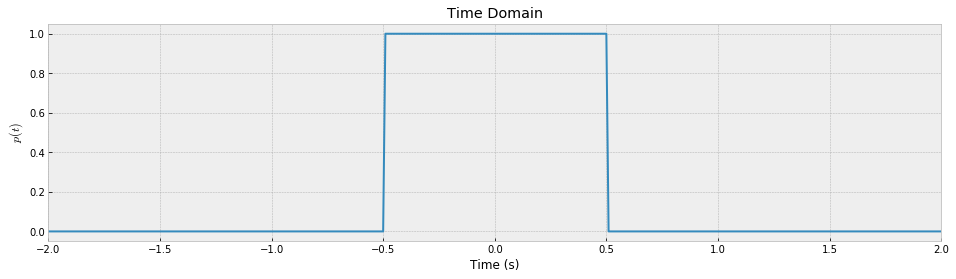

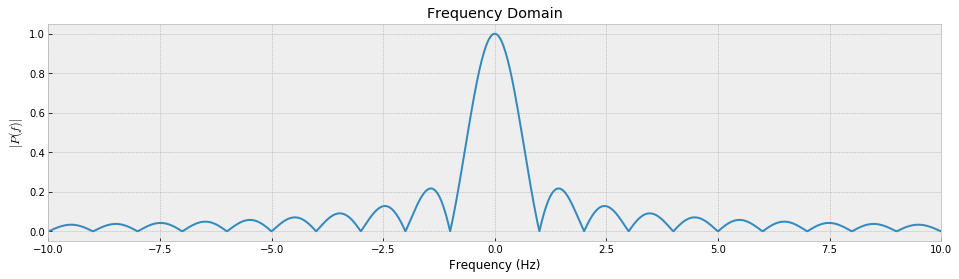

<Figure size 1152x288 with 0 Axes>

In [27]:
fs = 100 # sampling rate in Hz
###
t = np.arange(-5,5,1/fs)
x4 = ss.rect(t,1)
plt.figure(figsize=(16, 4))
plt.plot(t,x4);
#ylim([-1.1,1.1])
plt.xlim([-2,2])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');
f,X4 = ss.ft_approx(x4,t,4096)
plt.figure(figsize=(16, 4));
plt.plot(f,abs(X4));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');
plt.figure(figsize=(16, 4));

## Bandlimited channels

- We would like to design a digital communication system that the bandwidth is limited from $-W/2$ and $W/2$.
- Use the sinc function as the pulse, intead of retangular.

### Nyquist's sampling theorem: 

Bandwidth of $W$ Hz from $-W/2$ to $W/2$ needs a sampling rate of $W$ and it is recovered by a pulse $p(t) = \mathrm{sinc}(Wt)$. Therefore:

$$s(t) = \sum\limits_{n = -\infty}^{\infty} s(n/W) p (t - n/W)$$

Example from [Scikit-dsp-comm](https://scikit-dsp-comm.readthedocs.io/en/latest/nb_examples/Continuous-Time%20Signals%20and%20Systems%20using%20sigsys.html#Example:-Representing-a-Bandlimited-Signal)

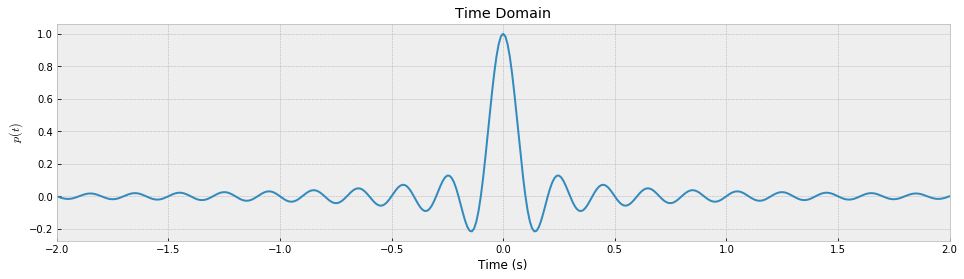

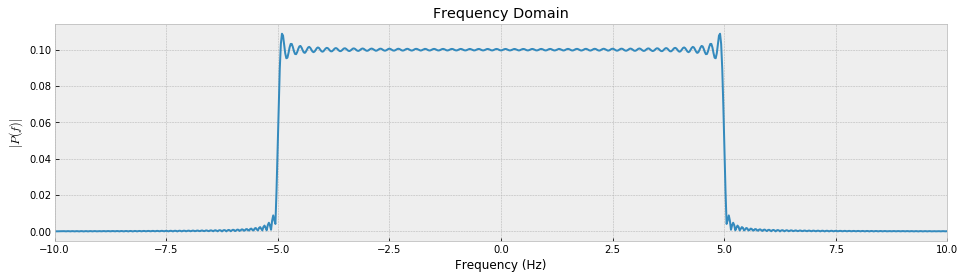

<Figure size 1152x288 with 0 Axes>

In [28]:
fs = 100 # sampling rate in Hz
W = 10 
###
t = np.arange(-5,5,1/fs)
x4 = np.sinc(W*t) 
plt.figure(figsize=(16, 4))
plt.plot(t,x4);
#ylim([-1.1,1.1])
plt.xlim([-2,2])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');
f,X4 = ss.ft_approx(x4,t,4096)
plt.figure(figsize=(16, 4));
plt.plot(f,abs(X4));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');
plt.figure(figsize=(16, 4));

- Limited in frequency, slow decay in time.

### Raised cosine pulse

- Interesting bandlimited signal:

$$p(t) = \mathrm{sinc}(W t) \dfrac{\cos(\pi b t W)}{1 - (2btW)^2}$$

- It leads to a trapezoidal frequency domain

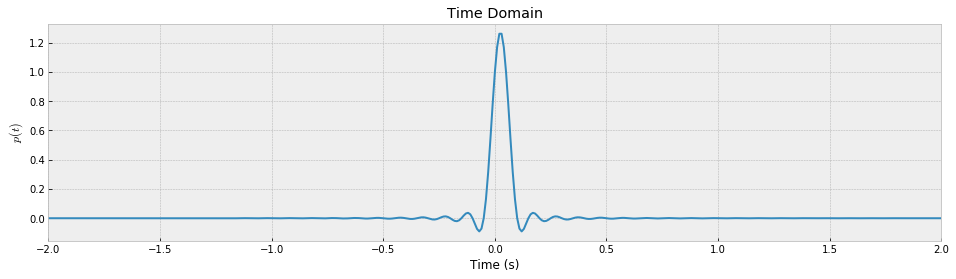

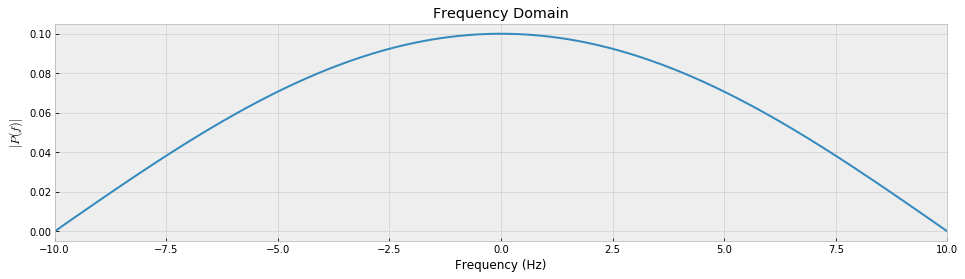

<Figure size 1152x288 with 0 Axes>

In [29]:
fs = 100 # sampling rate in Hz
W = 10 
b=1
###
t = np.arange(-5,5,1/fs)
x4 = np.sinc(W*t) * np.cos(b* np.pi * W * t ) /(1-(2*b*t*W)) 
plt.figure(figsize=(16, 4))
plt.plot(t,x4);
#ylim([-1.1,1.1])
plt.xlim([-2,2])
plt.title(r'Time Domain')
plt.xlabel(r'Time (s)')
plt.ylabel(r'$p(t)$');
f,X4 = ss.ft_approx(x4,t,4096)
plt.figure(figsize=(16, 4));
plt.plot(f,abs(X4));
plt.title(r'Frequency Domain')
plt.xlim([-10,10])
plt.xlabel(r'Frequency (Hz)')
plt.ylabel(r'$|P(f)|$');
plt.figure(figsize=(16, 4));